Disclaimer: 
This colab is based on the notebook published on Kaggle. The original version can be found [here](https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b#Feature-Scaling) 

<b>Problem Statement:</b> <p> Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use. </p>

<p>According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.</p>

<b>Goal: </b> <p>
The goal of this competition is to predict the energy consumption using building characteristics and climate and weather variables. </p>

# Importing libraries

In [52]:
import numpy as np
import pandas as pd
import datetime
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
import lightgbm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)

## Loading Files and Explorative Data Analysis

In [2]:
# load train and test data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# check the size of train and test sets
print("Number of train samples are", train.shape)
print("Number of test samples are", test.shape)

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [4]:
# initial look at the train data
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [5]:
# drop the id column from train data
del train['id']

In [6]:
train.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395


In [7]:
# find the correlation among the features
train.corr(method = 'pearson')

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
Year_Factor,1.000000,-0.036363,0.084143,-0.005052,0.132855,0.007913,-0.099628,-0.291137,-0.391312,-0.101799,-0.093735,-0.054079,0.051545,0.167406,-0.463176,-0.164931,-0.212332,-0.274205,-0.196895,0.114799,-0.309140,-0.097698,-0.406461,-0.103637,-0.190931,-0.408861,-0.072133,0.171693,0.338786,0.095091,0.180126,-0.078937,-0.097073,-0.144199,-0.062649,0.148017,0.360374,0.355420,-0.260890,-0.119175,-0.323793,0.032302,0.068750,-0.124418,0.182135,0.087389,-0.058627,0.137436,0.260270,0.263467,0.209500,0.185233,0.054718,-0.043701,-0.013635,0.231525,0.214651,0.233857,0.619227,-0.045179
floor_area,-0.036363,1.000000,0.100878,0.034947,0.097797,-0.148467,-0.137654,-0.104118,-0.106110,-0.120068,-0.042102,-0.121068,-0.098905,-0.011865,-0.087472,-0.100034,-0.030368,-0.057491,0.011626,0.028982,-0.023443,0.056028,0.026853,-0.009108,0.039562,0.021832,-0.007137,0.038335,0.023841,-0.013697,0.046048,0.055891,-0.102459,-0.059559,0.020746,-0.112179,-0.071890,0.026904,-0.085844,-0.059289,0.004669,0.045823,0.130198,0.062634,0.092503,0.074091,-0.111303,0.136123,0.135476,0.138712,0.140324,0.049897,0.022583,-0.031415,-0.009205,-0.000018,-0.003984,-0.000922,0.014282,0.073967
year_built,0.084143,0.100878,1.000000,-0.073857,0.047803,-0.011210,-0.032846,-0.080230,-0.000619,-0.020201,0.010372,-0.045171,-0.029848,-0.002352,-0.045250,-0.077966,-0.000861,-0.097668,-0.079245,-0.051633,-0.081202,-0.031165,0.006919,-0.093093,-0.052909,-0.036653,-0.103230,-0.048845,0.015295,-0.122823,-0.092156,-0.102312,-0.066947,-0.126027,-0.104420,-0.061495,-0.066770,-0.009608,-0.068626,-0.075244,-0.077388,-0.065614,0.073192,0.051926,-0.049473,-0.048279,-0.112555,0.046627,0.041619,0.063447,0.053247,-0.035519,-0.005065,-0.054164,NaN,0.001168,-0.009591,0.004945,0.084167,0.017162
energy_star_rating,-0.005052,0.034947,-0.073857,1.000000,-0.016783,0.144452,0.149421,0.081703,0.126411,0.137479,0.104399,0.134648,0.137160,0.077333,0.105996,0.100951,0.101430,-0.021194,-0.072969,0.005743,-0.039391,-0.106010,0.056200,-0.093468,-0.107087,-0.006585,-0.080867,-0.093280,-0.027211,-0.047610,-0.087785,-0.062982,0.076621,0.049684,0.037285,0.096028,0.067282,-0.012538,0.024659,0.026105,-0.050553,-0.098710,-0.133304,-0.109899,-0.140722,-0.111075,0.086425,-0.132442,-0.113404,-0.076361,-0.019048,-0.074993,0.019541,0.059382,NaN,-0.000992,0.002014,-0.000333,0.019387,-0.511012
ELEVATION,0.132855,0.097797,0.047803,-0.016783,1.000000,-0.255502,-0.233452,-0.345130,-0.153185,-0.184543,0.027383,-0.285815,-0.112014,0.068679,-0.176678,-0.258460,0.069062,-0.297420,-0.133906,0.075345,-0.416738,-0.080968,0.168690,-0.430781,-0.187750,-0.126061,-0.370227,-0.106940,0.059348,-0.204802,-0.014956,0.029897,-0.205325,-0.179472,-0.021019,-0.293057,-0.074790,0.206576,-0.399870,-0.276819,-0.207183,-0.109070,0.264434,-0.043577,0.009727,0.046208,-0.326495,0.309669,0.395252,0.561204,0.618740,0.062014,0.184423,0.104934,0.077188,0.050804,0.074144,0.040172,0.495345,0.011798
january_min_temp,0.007913,-0.148467,-0.011210,0.144452,-0.255502,1.000000,0.971149,0.658252,0.812591,0.857222,0.528175,0.

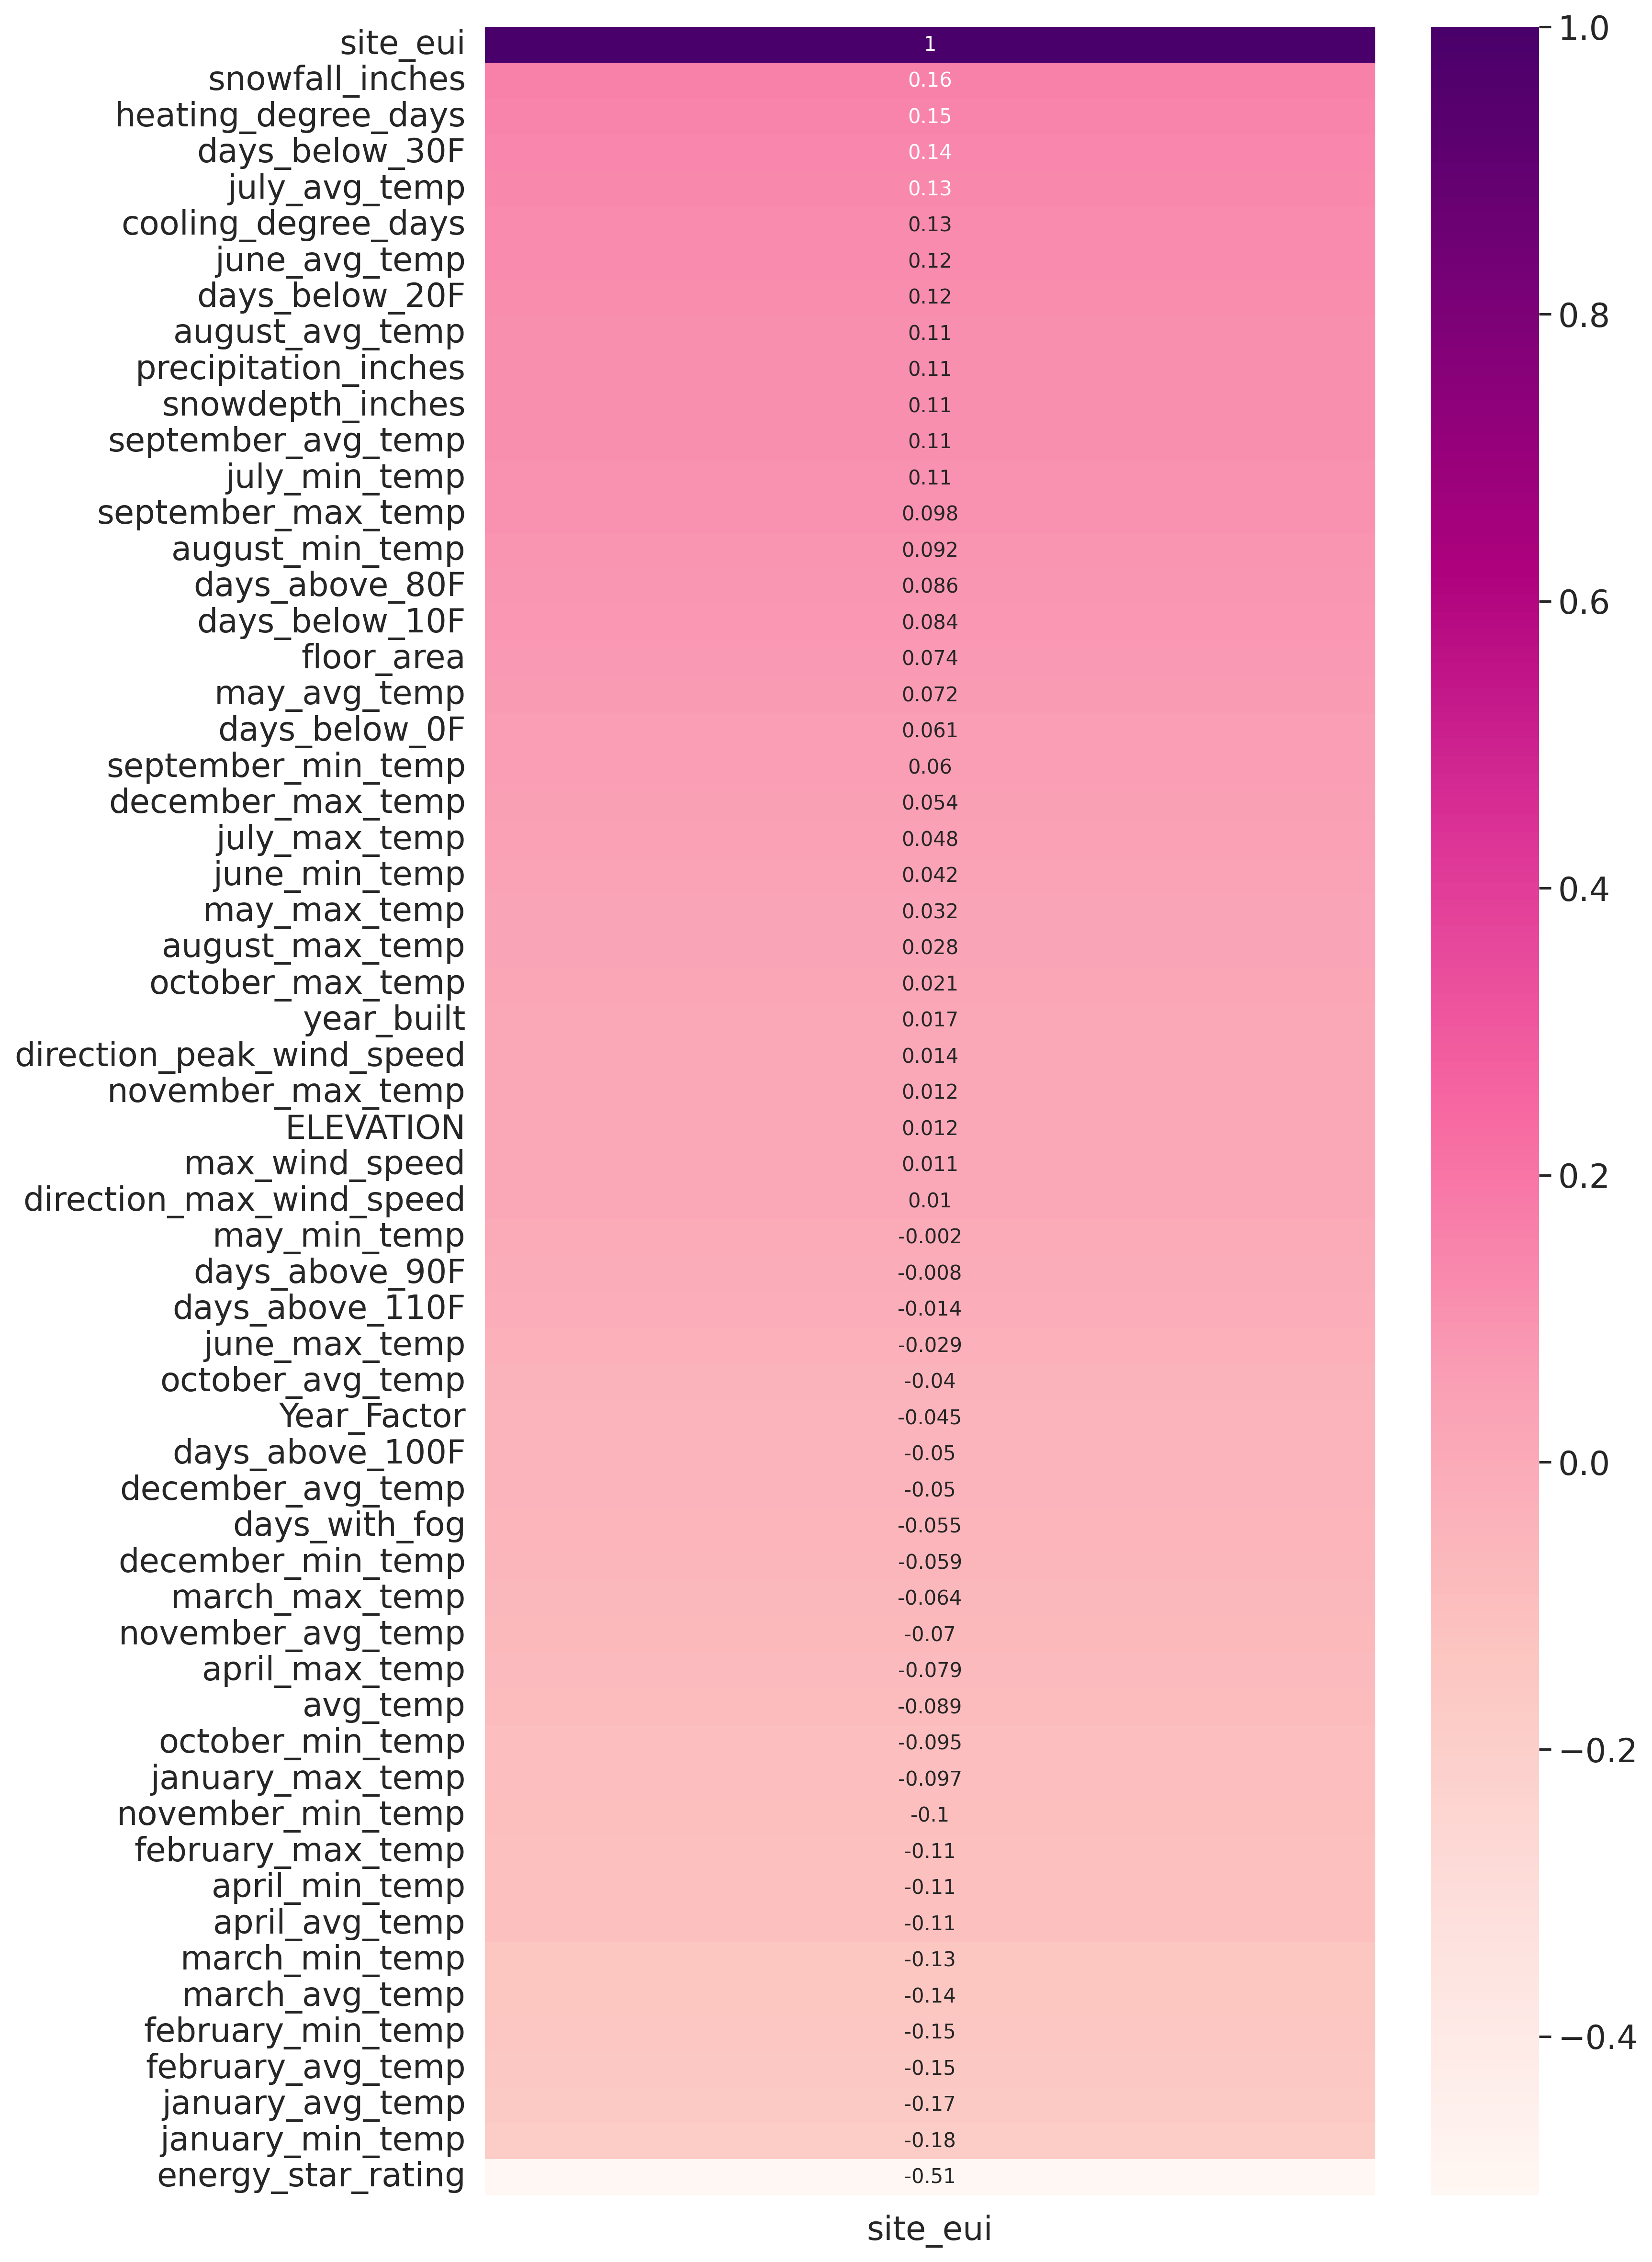

In [8]:
# the correlations between the target and the predictive features
ix = train.corr().sort_values('site_eui', ascending=False).index
train_sorted = train.loc[:, ix]

plt.figure(figsize=(10,20), dpi=300)
sns.heatmap(train_sorted.corr()[['site_eui']],
            cmap="RdPu",
            annot=True);

In [9]:
# drop direction_peak_wind_speed, direction_max_wind_speed, days_with_fog, max_wind_speed from train data
del train['direction_max_wind_speed']
del train['direction_peak_wind_speed']
del train['days_with_fog']
del train['max_wind_speed']

In [10]:
# drop direction_peak_wind_speed, direction_max_wind_speed, days_with_fog, max_wind_speed from test data
del test['direction_max_wind_speed']
del test['direction_peak_wind_speed']
del test['days_with_fog']
del test['max_wind_speed']

In [11]:
# the list of the comments in the train data
train.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [12]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395


In [13]:
# drop the rows in the train data that have missing values in the 'year_built' feature
train.dropna(subset = ['year_built'], inplace = True, axis = 0)

In [14]:
# check the number of rows in the test data
test.shape

(9705, 59)

## Imputation of missing values using KNNImputer

In [15]:
# create a subset of the train data that only contains columns with missing values that need to be imputed
new_train= train[['year_built','ELEVATION','floor_area','energy_star_rating']]
# # create a subset of the test data that only contains columns with missing values that need to be imputed
new_test = test[['year_built','ELEVATION','floor_area','energy_star_rating']]
# instantiate KNNImputer for train and test data
knnimpute = KNNImputer(n_neighbors=5)
knnimpute_test = KNNImputer(n_neighbors=5)
# impute the missing values in the newly created subsets of train and test data and assign the results 
# to new dataframes
energy_imputed_train = pd.DataFrame(knnimpute.fit_transform(new_train), columns = new_train.columns, index=new_train.index)
energy_imputed_test = pd.DataFrame(knnimpute_test.fit_transform(new_test), columns = new_test.columns, index=new_test.index) 



In [16]:
# check if there are any missing values in the train subset
energy_imputed_train['energy_star_rating'].isna().sum()

0

In [17]:
# check if there are any missing values in the test subset
energy_imputed_test['energy_star_rating'].isna().sum()

0

In [18]:
# rename the 'energy_star_rating' to 'energy_star_rating_imputed' in the new subsets
energy_imputed_train.rename(columns = {'energy_star_rating': 'energy_star_rating_imputed'},inplace = True)
energy_imputed_test.rename(columns = {'energy_star_rating': 'energy_star_rating_imputed'},inplace = True)

In [19]:
energy_imputed_test.head(5)

,year_built,ELEVATION,floor_area,energy_star_rating_imputed
0,1994.0,2.4,28484.0,37.0
1,1961.0,45.7,21906.0,55.0
2,1950.0,59.1,16138.0,1.0
3,1971.0,35.4,97422.0,34.0
4,1942.0,1.8,61242.0,35.0


In [20]:
energy_imputed_train.head(5)

,year_built,ELEVATION,floor_area,energy_star_rating_imputed
0,1942.0,2.4,61242.0,11.0
1,1955.0,1.8,274000.0,45.0
2,1951.0,1.8,280025.0,97.0
3,1980.0,1.8,55325.0,46.0
4,1985.0,2.4,66000.0,100.0


In [21]:
# remove the the previous energy_star_rating column  with missing values from train and test data and add the 'energy_star_rating_imputed' instead
train = train.drop(["energy_star_rating"], axis=1)
test = test.drop(["energy_star_rating"], axis=1)
energy_imputed_2_train = energy_imputed_train['energy_star_rating_imputed']
data2_train = pd.concat([train, energy_imputed_2_train], axis=1)
energy_imputed_2_test = energy_imputed_test['energy_star_rating_imputed']
data2_test = pd.concat([test, energy_imputed_2_test], axis=1)

In [22]:
# save the new imputed train and test data to csv files
data2_train.to_csv('data2_train.csv')
data2_test.to_csv('data2_test.csv')

In [23]:
# import the new train and test data 
train = pd.read_csv("data2_train.csv",index_col=0)
test = pd.read_csv("data2_test.csv",index_col=0)

In [24]:
# check the shape of the train data
print("the shape of the train data is: " , train.shape)
print("the shape of the test data is: " , test.shape)

the shape of the train data is:  (73920, 59)
the shape of the test data is:  (9705, 59)


In [25]:
train.head(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,energy_star_rating_imputed
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,11.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,45.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,97.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,48.406926,46.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,3.899395,100.0


In [26]:
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,id,energy_star_rating_imputed
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75757,37.0
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75758,55.0
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75759,1.0
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75760,34.0
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,75761,35.0


In [27]:
# change the Year_Factor column into an object type
train.Year_Factor = train.Year_Factor.astype('object')
test.Year_Factor = test.Year_Factor.astype('object')

In [28]:
# remove the outliers in the target feature in the train data
q99 = train.site_eui.quantile(q=[0.99])[0.99]

train = train[train.site_eui<q99]

In [29]:
# now the train data has 73180 rows down from 73920
train.shape

(73180, 59)

## One Hot Encoding

In [30]:
y = train["site_eui"]
X = train.drop(["site_eui"], axis=1)

In [31]:
# create a list of categorical columns that are going to be one hot encoded
categorical_cols = ['building_class','facility_type','State_Factor','Year_Factor']

In [32]:
# one-hot encoding of training data
X_cat = X[categorical_cols]
ohe = OneHotEncoder(drop = 'first',handle_unknown="ignore")
X_onehot = ohe.fit_transform(X_cat)
X_onehot = pd.DataFrame(X_onehot.toarray(), columns=ohe.get_feature_names_out(),index = X_cat.index)

X = pd.concat([X.drop(categorical_cols, axis=1), X_onehot], axis=1)


In [33]:
# one-hot encoding of testing data
X_cat = test[categorical_cols]
test_data_onehot = ohe.transform(X_cat)
test_data_onehot = pd.DataFrame(
    test_data_onehot.toarray(), columns=ohe.get_feature_names_out(), index = X_cat.index
)
test = pd.concat(
    [test.drop(categorical_cols, axis=1), test_data_onehot], axis=1
)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [34]:
# set aside the 'id' column for using it later ?
test_id = test['id']

In [35]:
test['id']

0       75757
1       75758
2       75759
3       75760
4       75761
        ...  
9700    85457
9701    85458
9702    85459
9703    85460
9704    85461
Name: id, Length: 9705, dtype: int64

In [36]:
# set the 'id' to be the index column of test data
test = test.set_index('id')


In [37]:
# test = test.drop('id')

In [38]:
test.head()

,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,...,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
75757,28484.0,1994.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75758,21906.0,1961.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75759,16138.0,1950.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75760,97422.0,1971.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75761,61242.0,1942.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Impute missing values in the 'Year_built' column in test data

In [39]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_freq.fit(test)
imp_freq.transform(test)

array([[2.8484e+04, 1.9940e+03, 2.4000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1906e+04, 1.9610e+03, 4.5700e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.6138e+04, 1.9500e+03, 5.9100e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [4.2393e+04, 2.0140e+03, 8.1200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5368e+04, 1.9920e+03, 8.1200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.5640e+04, 1.9940e+03, 2.6500e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [40]:
test = pd.DataFrame(imp_freq.transform(test), columns = test.columns, index=test.index)

In [41]:
# save the test data with imputed values to a new csv file and import it back
#year_imputed_test.to_csv('year_imputed_test.csv')
#test = pd.read_csv('year_imputed_test.csv')

In [42]:
test.shape

(9705, 125)

In [43]:
test.head()

,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,...,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,Year_Factor_2,Year_Factor_3,Year_Factor_4,Year_Factor_5,Year_Factor_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
75757,28484.0,1994.0,2.4,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.15,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.05,69.0,38.0,51.887097,66.0,342.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75758,21906.0,1961.0,45.7,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.15,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.05,69.0,38.0,51.887097,66.0,342.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75759,16138.0,1950.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.15,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.05,69.0,38.0,51.887097,66.0,342.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75760,97422.0,1971.0,35.4,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.15,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,43.0,58.05,69.0,38.0,51.887097,66.0,342.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75761,61242.0,1942.0,1.8,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.15,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48

## Scale the train and test data

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

## Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=50
)

## Baseline Model

In [46]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
DummyRegressor()
dummy_regr.predict(X_test)

dummy_regr.score(X_test, y_test)


-1.4978422375078182e-05

## Best Model (Light GBM)

In [ ]:
best_model = lightgbm.LGBMRegressor(learning_rate=0.1, max_depth=-1,
                                    n_estimators= 1000, num_leaves = 100, reg_alpha = 0.05)
# Fit X_scaled and y
best_model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, num_leaves=100, reg_alpha=0.05)

In [ ]:
best_model.score(X_test,y_test)

0.6092859014925598

In [ ]:
# create the solution dataframe with two columns: 'id' and 'site_eui' for submission to datathon
solution = best_model.predict(test)
solution = pd.DataFrame(solution, columns = ['site_eui'], index = test.index)
solution['id'] = solution.index
solution_columns = ['id','site_eui']
solution = solution[solution_columns]
solution = solution.reset_index(drop=True)
solution

,id,site_eui
0,75757,154.042519
1,75758,146.923656
2,75759,174.220396
3,75760,146.923656
4,75761,154.061575
...,...,...
9700,85457,54.841609
9701,85458,54.841609
9702,85459,54.841609
9703,85460,54.841609


In [ ]:
solution.to_csv('solution.csv', index = False)

## Ridge Regression

In [ ]:
ridge_reg = Ridge(random_state = 42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(ridge_reg, X_train, y_train, scoring='r2', cv=cv)
print('Mean R2: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean R2: 0.453 (0.016)


## Grid Search on Ridge Regression

In [ ]:
grid = {
 'alpha': [0.1,0.2,0.5,0.9,1],   # value of alpha = 0 is basically linear regression, so no point in picking it
 'fit_intercept': [True, False],
 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
 }
ridge_cv = GridSearchCV(estimator = ridge_reg, param_grid = grid, cv = 10,verbose = 1)
ridge_cv.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",ridge_cv.best_params_)
print("r2 :",ridge_cv.best_score_)


Fitting 10 folds for each of 60 candidates, totalling 600 fits
tuned hyperparameters :(best parameters)  {'alpha': 1, 'fit_intercept': True, 'solver': 'saga'}
r2 : 0.45356313848056695


## Grid Search on Random Forest

In [ ]:
grid = {
 'max_depth': [1,2,3,5,7],
 'max_features': ['sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 #'n_estimators': [200,400]}
forest_reg = RandomForestRegressor(random_state = 42)
forest_cv = GridSearchCV(estimator = forest_reg, param_grid = grid, cv = 10,verbose = 1)
forest_cv.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",forest_cv.best_params_)
print("r2 :",forest_cv.best_score_)

## AdaBoost Regression

In [55]:
ada_reg = AdaBoostRegressor(random_state = 42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(ada_reg, X_train, y_train, scoring='r2', cv=cv)
print('Mean R2: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean R2: 0.156 (0.053)


## Grid Search on AdaBoost 

In [ ]:
grid = {
 #'base_estimator': ['logisticregression','decisiontreeregressor','svc'],  
 'learning_rate': [0.1,0.5,1.0,1.5,2],
 'loss': ['linear', 'square', 'exponential'],
 'n_estimators': [10,200,1000]
 }
ada_cv = GridSearchCV(estimator = ada_reg, param_grid = grid, cv = 10,verbose = 1)
ada_cv.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",ada_cv.best_params_)
print("r2 :",ridge_cv.best_score_)


## XGBoost Regression

In [57]:
xgb_reg = XGBRegressor(random_state = 42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(xgb_reg, X, y, scoring='r2', cv=cv, n_jobs=-1)
print('Mean R2: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean R2: 0.479 (0.013)


## Grid Search on XGBoost

In [ ]:
grid = {
 #'base_estimator': ['logisticregression','decisiontreeregressor','svc'],  
 'eta': [0.01,0.05,0.1],
 'subsample': [0.5,0.7,1],
 'n_estimators': [10,200,1000],
 'max_depth': [1,5,7,10]


 }
xgb_cv = GridSearchCV(estimator = xgb_reg, param_grid = grid, cv = 10,verbose = 1)
xgb_cv.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",xgb_cv.best_params_)
print("r2 :",xgb_cv.best_score_)